
##  **Final Assignment**

The final assignment intends to summarize and compare the concepts and methods taught throughout the course. We will use a
 very simple task where the ground truth (optimal policies and value functions) are easy to establish and we will
 implement and evaluate the performance of some of the most important algorithms in solving the MDP. This task is called `Circle World`.

# Circle world

Consider an agent navigating a *circular environment*, consisting of a simple circular track divided into `n_states`.
 From any state, the agent may choose to step `left` or `right`. All actions lead to a reward $-1/(N-1)$, where $N=$ n_states -1, except for
 actions that lead the agent to the target state 0 which receive a reward of +1. States 0 and $N$ are connected to
 form a circle and the agent is randomly placed in the Circle (i.e. random initial state).

![](https://raw.githubusercontent.com/yuzhenqin90/RLcourse/main/final/CircleWorldMDP.png)

We will consider two variants of the task: an **episodic** version where 0 is a terminal state and a **continuing**
version where there is no terminal state and the agent can just move indefinitely around the circle.

The final assignment is built on this simple task--Circle World. It contains four parts, emcompassing all the content taught in the course:
 1. Markov Decision Processes (*1 Points*)
 2. Dynamic Programming (*4 Points*)
 3. Monte Carlo methods (*2 Points*)
 4. TD-learning (*3 Points*)

---
#### Requirements

In [155]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import time
np.random.seed(123456)


---

#### Preliminaries

Let's start by defining a generic environment base class.

**NOTE:** For simplicity and to make sure you are always able to run the exercises, we provide a simple
implementation in Python / numpy. You are encouraged to re-implement the MDP below using `gymnasium` (up to 2 bonus points,
 to a maximum final grade of 10, will be awarded if you do).

In [156]:
class CircleWorld():
	"""
	Generic base class for MDPs with finite state, action and reward spaces
	"""
	def __init__(self, n_states, n_actions, reward, task, gamma=1.0, state_labels=None, action_labels=None):
		"""
		n_states: number of states [0,...,N-1]
		n_actions: number of actions [0,...,N-1]
		reward: reward values
		task: episodic or continuing
		gamma: discounting factor
		"""
		self.n_states = n_states
		self.n_actions = n_actions
		self.state_labels = state_labels or np.arange(self.n_states)
		self.action_labels = action_labels or np.arange(self.n_actions)
		self.n_rewards = len(reward)
		self.reward = reward
		assert(task == 'episodic' or task == 'continuing')
		self.task = task
		self.gamma = gamma

	def reset(self):
		"""
		Sample initial state at start of the episode; assumed uniform
		"""
		return np.random.randint(self.n_states)

	def p_transition(self, s, a, s1, r):
		"""
		Transition density s x a => s1 x r
		"""
		# This only works for deterministic state transitions; otherwise override
		return np.float64((s1, r) == self.step(s, a))

	def step(self, s, a):
		"""
		Sample new state and reward when starting in s and taking action a
		:return new_state, reward_index: note that there are 3
		"""
		s1 = (s + 2 * a - 1) % self.n_states  # takes one step left or right
		if s1 == 0:
			r = 0
		else:
			r = 1
		return s1, r

	def sample_action(self, state, policy):
		# sample action from policy for a given state
		return np.random.choice(np.arange(self.n_actions), p=policy[state])

	def sample_episode(self, policy, T=None):
		"""
		Sample a finite horizon sequence from an MDP using some policy
		If the tasks is continuing then we sample exactly T steps
		If the task is episodic then we sample exactly one episode or reset until we sample T steps
		"""
		# sequence element is state, action, reward
		seq = []
		# randomly sample initial state NOTE: For exploring starts we would need to sample both states and actions. This is not needed for epsilon-greedy policies
		s = self.reset()

		if self.task == 'continuing':
			assert (T is not None)
			for t in range(T):
				a = self.sample_action(s, policy)
				(s1, r) = self.step(s, a)
				seq.append([s, a, self.reward[r]])
				s = s1
		else:
			t = 0
			while True:

				if T is None and self.is_terminal(s):
					break
				elif t == T:
					break

				a = self.sample_action(s, policy)
				if self.is_terminal(s):
					s1 = self.reset()
					r = 0
				else:
					(s1, r) = self.step(s, a)
				seq.append([s, a, self.reward[r]])
				s = s1
				t = t+1
		return seq

	def optimal_policy(self):
		"""
		For this simple task, the optimal policy is just to move to state zero as quickly as possible
		and then flip back and forth
		"""
		policy = np.zeros([self.n_states, self.n_actions])
		n = int(np.round(self.n_states/2))
		policy[:n, 0] = 1.0
		policy[n:, 1] = 1.0
		policy[self.terminal_states(), :] = 1.0 / self.n_actions
		return policy

	def random_deterministic_policy(self):
		"""
		Random choice of a deterministic action for each state
		"""
		return np.random.multinomial(1, [1.0 / self.n_actions for a in range(self.n_actions)], self.n_states).astype('float32')

	def nonterminal_states(self):
		"""
		:return: The set S of nonterminal states
		"""
		return [s for s in range(self.n_states) if not self.is_terminal(s)]

	def terminal_states(self):
		"""
		:return: The set S of terminal states
		"""
		return [s for s in range(self.n_states) if self.is_terminal(s)]

	def is_terminal(self, s):
		"""
		flags if s is a terminal state
		"""
		if self.task == "episodic":
			return s == 0
		else:
			return False

	def q_to_v(self, q, policy):
		"""
		Convert Q-value to state value
		:param q:
		:param policy:
		:return:
		"""
		v = np.zeros(self.n_states)
		for s in self.nonterminal_states():
			for a in range(self.n_actions):
				v[s] += policy[s, a] * q[s, a]
		return v

	def v_to_q(self, v):
		"""
		Convert state value to Q-value
		:param v:
		:return:
		"""
		q = np.zeros([self.n_states, self.n_actions])
		for s in self.nonterminal_states():
			for a in range(self.n_actions):
				q[s, a] = sum(self.p_transition(s, a, s1, r) * (self.reward[r] + self.gamma * v[s1])
				              for s1 in range(self.n_states) for r in range(self.n_rewards))
		return q

	# some simple rendering methods
	def __str__(self):
		str = "task: {0}\n".format(self.task)
		str += "states: {0}\n".format(self.state_labels)
		if self.terminal_states():
			str += "terminal states: {0}\n".format(self.terminal_states())
		str += "actions: {0}\n".format(self.action_labels)
		str += "rewards: {0}\n".format(self.reward)
		str += "discounting factor: {0}".format(self.gamma)
		return str

	def print_policy(self, policy):
		for s in range(self.n_states):
			a = np.random.choice(np.arange(self.n_actions), p=policy[s])
			print('state ' + str(self.state_labels[s]) + ' => action ' + str(self.action_labels[a]))

	def print_value(self, vf):
		"""
		:param vf: state value or action value function
		"""
		if vf.ndim == 1:
			for s in range(self.n_states):
				print('state ' + str(self.state_labels[s]) + ': ' + str(vf[s]))
		else:
			for s in range(self.n_states):
				for a in range(self.n_actions):
					print('state ' + str(self.state_labels[s]) + ' - action ' + str(self.action_labels[a] + ': ' + str(vf[s,a])))

To evaluate longer episodes, we will primarily use the continuing version and specify a maximum timespan $T$ where we
manually stop the simulation. Depending on the class of algorithms and their specificities, we will alternate between
 the continuing and episodic versions of the task.

In [157]:
mdpc = CircleWorld(n_states=10, n_actions=2, reward=[1.0, -1.0 /(10 - 1)], task='continuing', gamma=0.99,
                   state_labels=None, action_labels=['L', 'R'])
print(mdpc)

mdpe = CircleWorld(n_states=10, n_actions=2, reward=[1.0, -1.0 /(10 - 1)], task='episodic', gamma=1.,
                   state_labels=None, action_labels=['L', 'R'])
print(mdpe)

task: continuing
states: [0 1 2 3 4 5 6 7 8 9]
actions: ['L', 'R']
rewards: [1.0, -0.1111111111111111]
discounting factor: 0.99
task: episodic
states: [0 1 2 3 4 5 6 7 8 9]
terminal states: [0]
actions: ['L', 'R']
rewards: [1.0, -0.1111111111111111]
discounting factor: 1.0


Given the simplicity of the task, the optimal policy simply requires moving to state 0 as quickly as possible, so we
can construct an explicit optimal policy which will be used as baseline for comparisons and performance evaluations:

In [158]:
# to understand the policy, study the `optimal_policy` method defined above
pi_optimal_c = mdpc.optimal_policy()
mdpc.print_policy(pi_optimal_c)

state 0 => action L
state 1 => action L
state 2 => action L
state 3 => action L
state 4 => action L
state 5 => action R
state 6 => action R
state 7 => action R
state 8 => action R
state 9 => action R


In [159]:
pi_optimal_e = mdpe.optimal_policy()
pd.DataFrame({"p(L|s)": pi_optimal_e[:,0], "p(R|s)": pi_optimal_e[:,1]})
mdpe.print_policy(pi_optimal_e)

state 0 => action L
state 1 => action L
state 2 => action L
state 3 => action L
state 4 => action L
state 5 => action R
state 6 => action R
state 7 => action R
state 8 => action R
state 9 => action R


Having this ground truth ($\pi_{*}$, $v_{*}$ and $q_{*}$) we can evaluate how accurate are the corresponding estimates
 from the different algorithms ($\hat{\pi}$, $V(s)$ and $Q(s,a)$) by determining the mean-squared error between
 the. For example, having an estimate of $V$, the distance between this estimate and the true value function is given
  by:

$$MSE(V, v_{\pi}) = \sum_{s} (V(s) - v_{\pi}(s))^{2}$$

This way of measuring the accuracy of the estimates will be used throughout the assignment.

---

## 1. Markov Decision Processes *(1 point)*

**a**) Define a uniform / equiprobable stochastic policy (all actions have equal probability in all states). Note
that a policy in the current implementation should be defined as an [`n_states` x `n_actions`] array. ---------(**0.2 point**)

The cell below
illustrates an example deterministic policy :

In [160]:
example_policy = mdpc.random_deterministic_policy()
pol = pd.DataFrame({"p(L|s)": example_policy[:,0], "p(R|s)": example_policy[:,1]})
pol

,p(L|s),p(R|s)
0,1.0,0.0
1,0.0,1.0
2,0.0,1.0
3,1.0,0.0
4,1.0,0.0
5,0.0,1.0
6,1.0,0.0
7,0.0,1.0
8,0.0,1.0
9,1.0,0.0


In [161]:
def uniform_stochastic_policy(n_states, n_actions):
	"""
	Each action has equal probability in all states
	"""
	policy = np.full((n_states, n_actions), 1/n_actions, dtype=float)
	return policy

policy = uniform_stochastic_policy(10, 2)
print(policy)

[[0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]]


**b**) Sample an "episode" from the MDP (use `mdpc`, but cut-off the simulation at 500 timesteps), under the uniform
stochastic policy you defined above and plot the evolution of the returns
$G_{t}$ obtained under this policy, with discounting
factors $\gamma=1$, $\gamma=0.99$ and $\gamma=0.8$. Note that the sample episode is a sequence of `[state, action,
reward]`, so the returns have to be calculated from the rewards obtained. ---------(**0.2 point**)

In [162]:
def get_sequence_returns(sequence, discount):
    """
    Get the return for each time step of the provided sequence using the discount
    """

    returns = []

    for i in range(len(sequence)):
        
        new_discount = discount 
        
        # First value is not discounted
        returns.append(sequence[i][2])

        # Remaining values are discounted
        for item in sequence[i+1:]:
            reward = item[2]
            returns[i] += reward*new_discount
            new_discount *= discount

    return returns

Text(0.5, 1.0, 'Returns vs Time Step for Uniform Stochastic Policy, Continuous, T=500')

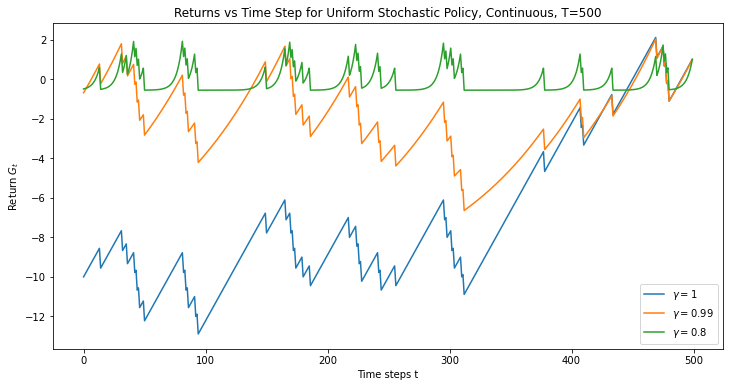

In [163]:
TIMESTEPS = 500
policy = uniform_stochastic_policy(mdpc.n_states, mdpc.n_actions)
sequence = mdpc.sample_episode(policy, TIMESTEPS)
discounts = [1, 0.99, 0.8]

plt.figure(figsize=(12,6))

# Plot the returns for each discount factor
for discount in discounts:
    returns = get_sequence_returns(sequence, discount)
    timesteps = np.arange(0,TIMESTEPS)
    plt.plot(timesteps, returns, label=r'$\gamma=$'+str(discount))

plt.legend(loc="lower right")
plt.xlabel("Time steps t")
plt.ylabel(r"Return $G_t$")
plt.title("Returns vs Time Step for Uniform Stochastic Policy, Continuous, T=500")

**c**) What is the problem of using $\gamma=1$ for this task? How was this problem solved in **b**? ---------(**0.2 point**)

The problem with using $\gamma=1$ is that we require the return $G_t$ to be finite and if the task is continuous and $\gamma = 1$ then the return is infinite. We solved this problem in b by limiting the number of steps to 500.

**d**) Sample an episode from the episodic version of the task (implemented above as `mdpe`), under the uniform
stochastic policy
and plot the evolution of the returns
$G_{t}$ obtained under this policy, with discounting
factors $\gamma=1$, $\gamma=0.99$ and $\gamma=0.8$. ---------(**0.2 point**)

Text(0.5, 1.0, 'Returns vs Time Step for Uniform Stochastic Policy, Episodic')

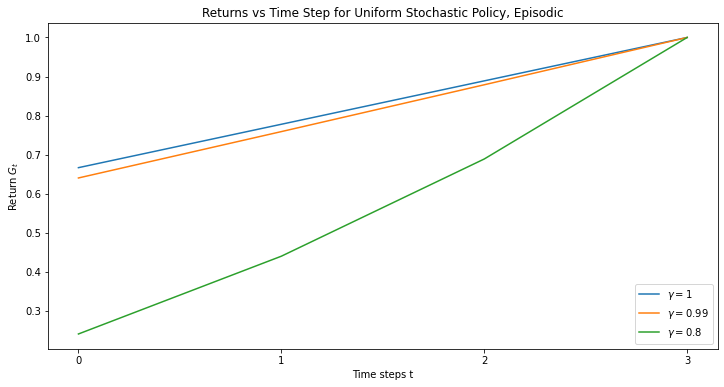

In [164]:
policy = uniform_stochastic_policy(mdpe.n_states, mdpe.n_actions)
sequence = mdpe.sample_episode(policy)
discounts = [1, 0.99, 0.8]

plt.figure(figsize=(12,6))

# Plot the returns for each discount factor
for discount in discounts:
    returns = get_sequence_returns(sequence, discount)
    timesteps = np.arange(0,len(sequence))
    plt.plot(timesteps, returns, label=r'$\gamma=$'+str(discount))

plt.legend(loc="lower right")
plt.xticks(np.arange(0, len(sequence), 1))
plt.xlabel("Time steps t")
plt.ylabel(r"Return $G_t$")
plt.title("Returns vs Time Step for Uniform Stochastic Policy, Episodic")

**e**) Rerun the continuing task with a fixed $T=500$, using the pre-implemented deterministic policy and plot the
evolution of the returns $G_{t}$ obtained under this policy, with discounting
factors $\gamma=1$, $\gamma=0.99$ and $\gamma=0.8$.
---------(**0.2 point**)

[[5, 0, -0.1111111111111111], [4, 0, -0.1111111111111111], [3, 0, -0.1111111111111111], [2, 0, -0.1111111111111111], [1, 1, -0.1111111111111111], [2, 0, -0.1111111111111111], [1, 1, -0.1111111111111111], [2, 0, -0.1111111111111111], [1, 1, -0.1111111111111111], [2, 0, -0.1111111111111111], [1, 1, -0.1111111111111111], [2, 0, -0.1111111111111111], [1, 1, -0.1111111111111111], [2, 0, -0.1111111111111111], [1, 1, -0.1111111111111111], [2, 0, -0.1111111111111111], [1, 1, -0.1111111111111111], [2, 0, -0.1111111111111111], [1, 1, -0.1111111111111111], [2, 0, -0.1111111111111111], [1, 1, -0.1111111111111111], [2, 0, -0.1111111111111111], [1, 1, -0.1111111111111111], [2, 0, -0.1111111111111111], [1, 1, -0.1111111111111111], [2, 0, -0.1111111111111111], [1, 1, -0.1111111111111111], [2, 0, -0.1111111111111111], [1, 1, -0.1111111111111111], [2, 0, -0.1111111111111111], [1, 1, -0.1111111111111111], [2, 0, -0.1111111111111111], [1, 1, -0.1111111111111111], [2, 0, -0.1111111111111111], [1, 1, -0.111

Text(0.5, 1.0, 'Returns vs Time Step for Random Deterministic Policy, Continuous, T=500')

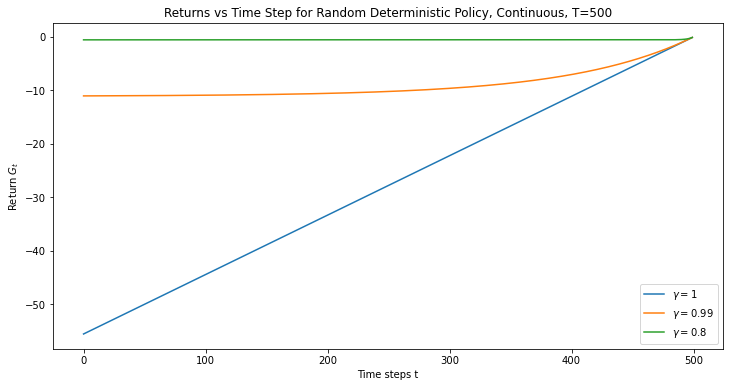

In [165]:
policy = mdpc.random_deterministic_policy()
sequence = mdpc.sample_episode(policy, 500)
print(sequence)
discounts = [1, 0.99, 0.8]

plt.figure(figsize=(12,6))

# Plot the returns for each discount factor
for discount in discounts:
    returns = get_sequence_returns(sequence, discount)
    timesteps = np.arange(0,len(sequence))
    plt.plot(timesteps, returns, label=r'$\gamma=$'+str(discount))

plt.legend(loc="lower right")
plt.xlabel("Time steps t")
plt.ylabel(r"Return $G_t$")
plt.title("Returns vs Time Step for Random Deterministic Policy, Continuous, T=500")

### 2. Dynamic Programming *(4 points)*


**a**) **Policy evaluation**: DP-prediction

**a.1**) Write a policy evaluation function, which computes the state-value function from a given policy, $v_{\pi}$. ---------(**1 point**)

In [166]:
def policy_evaluation(mdp, policy, theta=1e-8, V=None, max_t=None):
	"""
	Iterative policy evaluation
	:param mdp: the mdp object
	:param policy: the policy to evaluate
	:param value: the value function (can be initialized)
	:param theta: cutoff for policy evaluation
	:param max_t: maximum number of steps
	Returns: State value function V
	"""
	
	assert isinstance(mdp,CircleWorld)
	
	# Conditions for convergence
	assert (mdp.task == 'episodic' or mdp.gamma < 1.0)
	
	# Init V
	if V is None:
		V = np.zeros(mdp.n_states)

	# Evaluate policy iteratively
	t = 0
	while True:
		delta = 0
		
		for state in mdp.nonterminal_states():
			v = V[state]
			V[state] = 0
			for action, prob in enumerate(policy[state]):
				s1, r = mdp.step(state, action)
				V[state] += prob*mdp.p_transition(state, action, s1, r)*(mdp.reward[r] + mdp.gamma*V[s1]) 
			delta = max(delta, abs(v-V[state]))
		t += 1
		
		# Stopping conditions
		if delta < theta:
			print(f"Converged in {t} iterations")
			break

		if max_t is not None:
			if t >= max_t:
				print("Did not converge")
				break

	return V

**a.2**) Evaluate the optimal policy generated above, using the `policy_evaluation` function you just implemented.
Compare the value function ($v_{\pi}$) for the optimal policy with that obtained for the deterministic random policy
(pre-implemented) and for the stochastic, uniform random policy you implemented in 1a). Print or plot the results. ---------(**0.4 point**)

### Note to TA marking assignment
It was not clear from the question if we should be plotting for the continuous or the episodic case so I have done both below.

Converged in 6 iterations
Converged in 914 iterations
Did not converge
Converged in 913 iterations
Converged in 166 iterations
Converged in 502 iterations


Text(0.5, 1.0, 'Continuous Uniform-Stochastic')

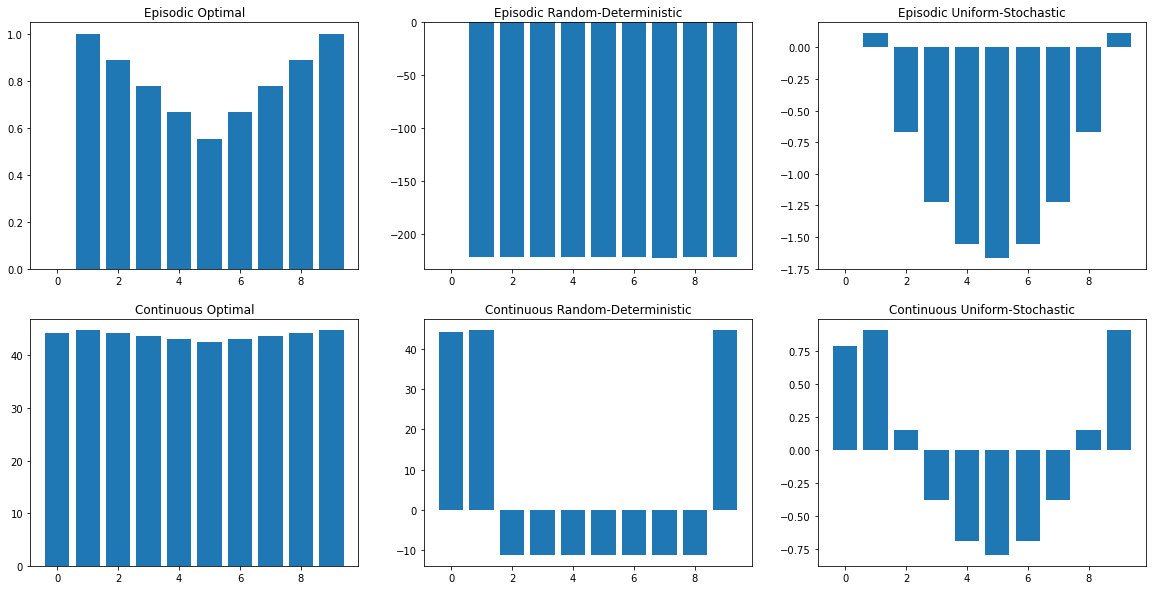

In [167]:
V1 = policy_evaluation(mdpe, mdpe.optimal_policy(), max_t=1000)
V2 = policy_evaluation(mdpc, mdpc.optimal_policy(), max_t=1000)
V3 = policy_evaluation(mdpe, mdpe.random_deterministic_policy(), max_t=1000)
V4 = policy_evaluation(mdpc, mdpc.random_deterministic_policy(), max_t=1000)
V5 = policy_evaluation(mdpe, uniform_stochastic_policy(mdpe.n_states, mdpc.n_actions), max_t=1000)
V6 = policy_evaluation(mdpc, uniform_stochastic_policy(mdpc.n_states, mdpc.n_actions), max_t=1000)

xs = np.arange(0, len(V1), 1)
fig, ax = plt.subplots(2, 3, figsize=(20,10))
ax[0][0].bar(xs, V1)
ax[0][0].set_title("Episodic Optimal")
ax[0][1].bar(xs, V3)
ax[0][1].set_title("Episodic Random-Deterministic")
ax[0][2].bar(xs, V5)
ax[0][2].set_title("Episodic Uniform-Stochastic")

ax[1][0].bar(xs, V2)
ax[1][0].set_title("Continuous Optimal")
ax[1][1].bar(xs, V4)
ax[1][1].set_title("Continuous Random-Deterministic")
ax[1][2].bar(xs, V6)
ax[1][2].set_title("Continuous Uniform-Stochastic")

**a.3**) Evaluate the optimal policies for the continuing and the episodic tasks and plot the resulting value
functions $v_{*}$. What is the main difference in state values? Why is this the case? ---------(**0.4 point**)

Converged in 6 iterations
Converged in 914 iterations


Text(0.5, 1.0, 'Continuous Optimal')

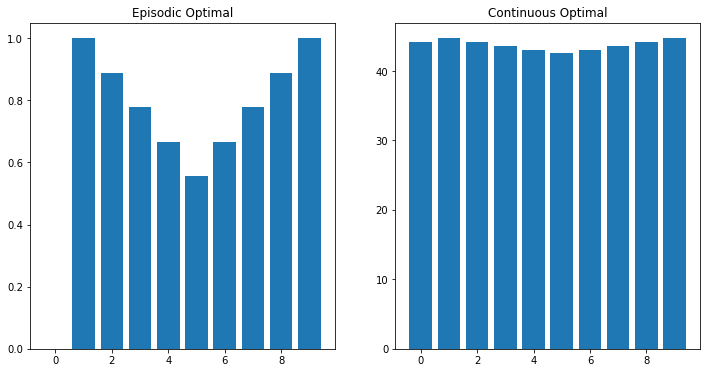

In [168]:
V1 = policy_evaluation(mdpe, mdpe.optimal_policy(), max_t=1000)
V2 = policy_evaluation(mdpc, mdpc.optimal_policy(), max_t=1000)

xs = np.arange(0, len(V1), 1)
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].bar(xs, V1)
ax[0].set_title("Episodic Optimal")

ax[1].bar(xs, V2)
ax[1].set_title("Continuous Optimal")

The main difference in state values is that the state values for the continuous task are much higher than the state values for the episodic task. Additionally, the value of state 0 in the episodic task is 0, while in the continuous case it is above 40. 

The reason state 0 has a value of zero is because in the policy evaluation method we only update those state values corresponding to non-terminal states. In the episodic task state 0 is a terminal state and thus must always have a value of 0. In the continuous case state 0 is no longer a terminal state, and thus can have a nonzero value. 

The reason that the continuous task has higher rewards compared to the episodic task is because the reward of +1 at state 0 can be obtained multiple times in the continuous task, since going into state 0 does not terminate the task. However, the agent is prevented from gaining infinite rewards by oscillating between state 0 and 1 for example, by the fact that $\gamma < 1$

**b**) **Policy iteration** versus **value iteration**: DP-control

The control problem is solved by following a sequence of policy *evaluation* and *improvement*:

$$\pi_{0} \stackrel{\mathrm{E}}{\longrightarrow} v_{\pi_{0}} \stackrel{\mathrm{I}}{\longrightarrow} \pi_{1}
\stackrel{\mathrm{E}}{\longrightarrow} v_{\pi_{1}} \stackrel{\mathrm{I}}{\longrightarrow} \pi_{2}
\stackrel{\mathrm{E}}{\longrightarrow} \cdots \stackrel{\mathrm{I}}{\longrightarrow} \pi_{*}
\stackrel{\mathrm{E}}{\longrightarrow} v_{*}$$

In the exercise above, we have implemented the `policy_evaluation` step, which, given a policy $\pi$, returns the
corresponding state value function $v_{\pi}$.


**b.1**) Implement a `policy_improvement` function
where, given a policy and a state value function, computes action-values $q_{\pi}$ and uses those to improve the
policy by selecting the actions with the highest $q_{\pi}$ for every given state, i.e. acting greedy with respect to
the Q-values to improve the policy. ---------(**1 point**)

In [169]:
def policy_improvement(mdp, policy, V):
	"""
	Policy improvement operates directly on the input policy.
	:param mdp:
	:param policy:
	:param V: state-value function
	returns: policy, policy_stable (bool)
	"""
	assert isinstance(mdp, CircleWorld)
	new_policy = np.full((mdp.n_states, mdp.n_actions), 0, dtype=float)
	policy_stable = True

	for state in range(mdp.n_states):

		# Place to store action values for this state
		action_values = []

		# Collect value of performing each action in this state
		for action in range(mdp.n_actions):
			s1, r = mdp.step(state, action)
			action_val = mdp.p_transition(state, action, s1, r)*(mdp.reward[r] + mdp.gamma*V[s1])
			action_values.append(action_val)

		# There may be multiple max_actions, so split prob evenly between them
		max_val = np.max(action_values)
		max_actions = np.where(action_values == max_val)[0]
		prob_per_max_action = 1/len(max_actions)

		# For each max action, assign equal probability and prob = 0 to non maximal actions
		for action in max_actions:
			new_policy[state][action] = prob_per_max_action

		# If new policy is different from old policy then policy is not stable
		if not np.array_equal(policy[state], new_policy[state]):
			policy_stable = False

	return new_policy, policy_stable

**b.2**) Implement the complete `policy_iteration` algorithm by interleaving
steps of *evaluation* and *improvement*, using the functions implemented above. Note: this should be implemented as a
function that takes in an initial policy $\pi_{0}$ and returns a final (optimal) policy and a
sequence (list) of value functions. Run your *policy iteration* algorithm starting with the stochastic uniform policy,
print the resulting policy and plot the evolution of the evaluated value functions. ---------(**0.6 point**)

In [176]:
def policy_iteration(mdp, policy):
	"""
	returns policy and list of value estimates per state and wall-clock time
	operates directly on the input policy
	"""
	start = time.time()
	V = None
	Vs = []

	while True:
		V = policy_evaluation(mdp, policy)
		new_policy, policy_stable = policy_improvement(mdp, policy, V)
		policy = new_policy
		Vs.append(V.copy())
		if policy_stable:
			break

	end = time.time()
	print("{0} iterations completed in {1} ms".format(len(Vs), end-start))

	return policy, Vs, end - start

In [177]:
optimized_policy_pi, value_functions_pi, timings_pi = policy_iteration(mdpc, uniform_stochastic_policy(mdpc.n_states, mdpc.n_actions))
mdpc.print_policy(optimized_policy_pi)

Converged in 502 iterations
Converged in 914 iterations
Converged in 914 iterations
3 iterations completed in 0.08070850372314453 ms
state 0 => action R
state 1 => action L
state 2 => action L
state 3 => action L
state 4 => action L
state 5 => action L
state 6 => action R
state 7 => action R
state 8 => action R
state 9 => action R


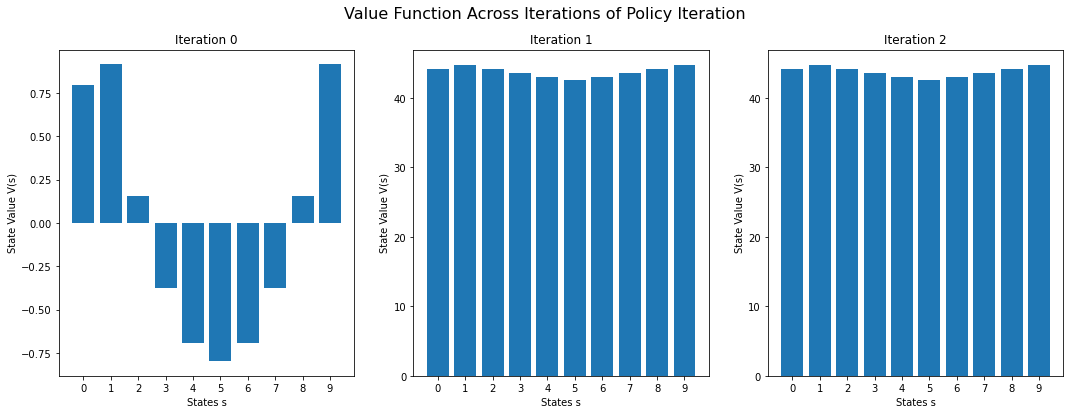

In [203]:
# plots
fig, ax = plt.subplots(1, 3, figsize=(18,6), sharex=True)
fig.suptitle("Value Function Across Iterations of Policy Iteration", fontsize=16)
plt.xticks(np.arange(0, mdpc.n_states, 1))

for a in ax:
    a.set_xlabel("States s")
    a.set_ylabel("State Value V(s)")

states = range(mdpc.n_states)
for iteration, v in enumerate(value_functions_pi):
    ax[iteration].bar(states, v)
    ax[iteration].set_title(f"Iteration {iteration}")






**b.3**) Implement the `value_iteration` algorithm, where you skip the policy improvement steps until you reach the
optimal value function, from which a final policy can be computed.

$$\pi_{0} \stackrel{\mathrm{E}}{\longrightarrow} v_{0} {\longrightarrow} v_{1} {\longrightarrow} v_{2}
{\longrightarrow} \cdots {\longrightarrow} v_{*} \rightarrow \pi_{*}$$

Note: this should be implemented as a function which starts with an all-zeros value function $v_{0}=0 \
\forall s \in \mathcal{S}$ and returns a final (optimal) policy and a sequence of value functions. To construct the
final policy, you will also need a function to construct a policy based on a state value function (this is provided below for simplicity).
Run your *value iteration* algorithm starting with the stochastic uniform policy, print
 the resulting policy and plot the evolution of the value functions. ---------(**0.6 point**)

In [173]:
def policy_construction(mdp, V):
	"""
	Derive policy from value function
	"""
	policy = np.ones([mdp.n_states, mdp.n_actions]) / mdp.n_actions
	for s in range(mdp.n_states):
		action_values = np.zeros(mdp.n_actions)
		for a in range(mdp.n_actions):
			action_values[a] = sum(mdp.p_transition(s, a, s1, r) * (mdp.reward[r] + mdp.gamma * V[s1])
			                       for s1 in range(mdp.n_states) for r in range(mdp.n_rewards))
		best_action = np.argmax(action_values)
		# Update Policy
		policy[s, :] = 0
		policy[s, best_action] = 1
	return policy

In [174]:
def value_iteration(mdp, theta=1e-8, max_t=None):
	"""
	returns policy and list of value estimates per state
	"""
	start = time.time()
	V = np.zeros(mdp.n_states)

	# Evaluate policy iteratively
	t = 0
	Vs = []
	while True:
		# TODO

	# Output deterministic policy
	policy = policy_construction(mdp, V)
	end = time.time()
	print("{0} iterations completed in {1} ms".format(len(Vs), end-start))
	return policy, Vs, end - start

IndentationError: expected an indented block after 'while' statement on line 11 (1665171119.py, line 15)

In [ ]:
optimized_policy_vi, value_functions_vi, timings_vi = value_iteration(mdpc)
mdpc.print_policy(optimized_policy_vi)

In [ ]:
# plots

Given that we know the ground truth for this simple problem, we can evaluate the performance of the
different algorithms by measuring how far they are from the optimal solution. So, we can calculate the Mean Squared
Error (MSE) and plot it as a function of time to see how fast and accurate are the different algorithms. **Note:** In
 this initial example, we will provide a base implementation, but this procedure will be repeated to
 evaluate the different classes of solutions (here, the MSE is plotted as a function of computing time, but in the
 model-free algorithms it will be plotted as a function of the number of episodes used).

  ***Notice:*** This is not a question.

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

time_axis_pi = np.arange(0, timings_pi, timings_pi / (len(value_functions_pi)+1))[:len(value_functions_pi)]
ax[0].plot(time_axis_pi, list(map(lambda x: np.mean((x - V_c)**2), value_functions_pi)), '-o', label='policy iteration')
time_axis_vi = np.arange(0, timings_vi, timings_vi / (len(value_functions_vi)+1))[:len(value_functions_vi)]
ax[0].plot(time_axis_vi, list(map(lambda x: np.mean((x - V_c)**2), value_functions_vi)), '-x', label='value iteration')
ax[0].set_xlabel('Time [ms]')
ax[0].set_ylabel('MSE')
ax[0].set_title('State value')

ax[1].plot(time_axis_pi, list(map(lambda x: np.mean((mdpc.v_to_q(x) - mdpc.v_to_q(V_c))**2), value_functions_pi)),
           '-o', label='policy iteration')
ax[1].plot(time_axis_vi, list(map(lambda x: np.mean((mdpc.v_to_q(x) - mdpc.v_to_q(V_c))**2), value_functions_vi)),
           '-o', label='value iteration')
ax[1].set_xlabel('Time [ms]')
ax[1].set_ylabel('MSE')
ax[1].set_title('Q-value')
plt.legend()

print("Policy MSE: {} (policy iteration)".format(np.mean(np.array(pi_optimal_e) - np.array(optimized_policy_pi))**2))
print("Policy MSE: {} (value iteration)".format(np.mean(np.array(pi_optimal_e) - np.array(optimized_policy_vi))**2))

### 3. Monte Carlo Methods *(2 points)*

For this exercise, we will use the *episodic* version of the MDP (`mdpe` instantiated above).

**a**) Why do we need to use an *episodic* task? ---------(**0.2 point**)

**b**) **MC Prediction**: Implement an *on-policy, first-visit MC* algorithm to estimate the state-value function for
the optimal policy
. This should be provided as a function `mc_prediction` that takes in the initial policy and
 a parameter specifying how many sample episodes to run. Use your implementation to calculate the approximate state
 value function $V_{\pi}$ for the optimal policy $\pi_{*}$. Plot the MSE between the estimated value function and the
  true optimal $v_{*}$ as a function of number of episodes, i.e. how the accuracy of the estimate evolves across
  episodes. ---------(**0.9 point**)

In [ ]:
def mc_prediction(mdp, policy, num_simulations=30):
	# Conditions for convergence
	assert(mdp.task == 'episodic')
	V = np.zeros(mdp.n_states)

	# TODO

	return V, Vs

In [ ]:
V, Vs = mc_prediction(mdpe, mdpe.optimal_policy(), num_simulations=200)

In [ ]:
# plots

**c**) **MC Control**: Implement an *on-policy, first-visit MC* algorithm to optimize the policy. To do this, you will
need to
estimate the Q-value function (computing returns after first visit to state-action pairs) and use it to take an
$\epsilon$-greedy action selection to gradually improve the policy. This should be provided as a function
`mc_control` that takes in the initial policy, the number of episodes to use and `epsilon` to set the mininum action
probability. Run for 200 episodes and plot the MSE between the estimated q-value function and the
  true optimal $q_{*}$ as a function of number of episodes. Note: you can obtain the $q_{*}$ from
$v_{*}$ using the method `mdpe.v_to_q()`. ---------(**0.9 point**)

In [ ]:
def mc_control(mdp, policy, num_simulations=30, epsilon=0.01):
	"""
	Run the Monte Carlo First Visit On-Policy algorithm and return the estimated
	policy, Q (state action) values, and returns (rewards) dict.
	Uses epsilon-soft policies instead of exploring starts
	:param mdp:
	:param policy: any epsilon soft policy; e.g. mdp.uniform_stochastic_policy()
	:param num_simulations : int Number of episodes for the policy iteration process
	:param epsilon: epsilon-soft minimum probability

	:return policy: numpy.ndarray Estimated Policy
	:return Q: numpy.ndarray Estimated Q (state-action) values
	:return R: dict Returns obtained for every state
	"""
	# Conditions for convergence
	assert(mdp.task == 'episodic')

	Q = np.zeros([mdp.n_states, mdp.n_actions])

	# TODO

	return policy, Qs

In [ ]:
policy0 = uniform_stochastic_policy(mdpe.n_states, mdpe.n_actions)
policy_mc, Qs_mc = mc_control(mdpe, policy0, num_simulations=10000, epsilon=0.01)

In [ ]:
# plots

In [ ]:
print("Policy MSE: {}".format(np.mean(np.array(pi_e) - np.array(policy_mc))**2))

---

### 4. TD-methods *(3 points)*

Note that, despite the fact that TD-learning can handle continuing tasks, we will constrain the study to episodic
tasks because the nature of the environment would result in infinite loops where no stable solutions can be found.


**a**) **TD Prediction**: Implement and run TD(0) to estimate the value function under the optimal policy. Run the
algorithm for 500 sample episodes with a fixed $\alpha=0.01$. Plot the result as the MSE between the state
 value estimates $V$ and the ground truth $v_{\pi}$ as a function of number of episodes, i.e. how
 the accuracy of the estimate evolves across
  episodes. ---------(**1 point**)

In [ ]:
def td0_prediction(mdp, policy, num_simulations=30, alpha = 0.01):
	"""
	TD(0) prediction algorithm
	:param mdp:
	:param policy:
	:param num_simulations: number of episodes to sample
	:param alpha: fixed learning rate
	:return:
	"""
	# Conditions for convergence; note that we can also run on continuing problems
	assert(mdp.task == 'episodic')
	V = np.zeros(mdp.n_states)
	Vs = []

	# TODO

	return V, Vs

In [ ]:
td_v, td_vs = td0_prediction(mdpe, mdpe.optimal_policy(), num_simulations=500, alpha=0.01)

In [ ]:
# plots

**b**) **On-policy TD control**: Implement and run the SARSA algorithm to estimate the optimal policy. Remember
that policy updates are $\epsilon$-greedy. Start from a uniform stochastic policy and run the algorithm for 10000
episodes, with a fixed learning rate $\alpha=0.01$ and $\epsilon=0.1$. Plot the MSE between the estimated q-value
function and the true optimal $q_{*}$ as a function of number of episodes. Note: you can obtain the $q_{*}$ from
$v_{*}$ using the method `mdpe.v_to_q()`. ---------(**1 point**)

In [ ]:
def sarsa(mdp, num_simulations=30, alpha=0.01, epsilon=0.1):
	"""
	SARSA on-policy control
	:param mdp:
	:param num_simulations: number of sample episodes
	:param alpha: learning rate
	:param epsilon: minimum action selection probability
	:return:
	"""
	# Conditions for convergence; note that we can also run on continuing problems
	assert (mdp.task == 'episodic')
	Q = np.zeros([mdp.n_states, mdp.n_actions])
	policy = uniform_stochastic_policy(mdp.n_states, mdp.n_actions)
	Qs = []

	# TODO

	return policy, Q, Qs

In [ ]:
policy_sarsa, Q, Qs = sarsa(mdpe, num_simulations=10000, alpha=0.01, epsilon=0.1)

In [ ]:
# plots

**c**) **Off-policy TD control**: Implement and run the Q-learning algorithm to estimate the optimal policy. Start from a uniform stochastic policy and run the algorithm for 10000
episodes, with a fixed learning rate $\alpha=0.01$ and $\epsilon=0.1$. Plot the MSE between the estimated q-value
function and the true optimal $q_{*}$ as a function of number of episodes. ---------(**1 point**)

In [ ]:
def qlearning(mdp, behavioral_policy, num_simulations=30, alpha=0.01, epsilon=0.1):
	# Conditions for convergence; note that we can also run on continuing problems
	assert(mdp.task == 'episodic')

	Q = np.zeros([mdp.n_states, mdp.n_actions])
	Qs = []

	for t in range(num_simulations):
		s = mdp.reset()
		while not mdp.is_terminal(s):
			a = mdp.sample_action(s, behavioral_policy)
			(s1, r) = mdp.step(s, a)

			# TODO: complete

		Qs.append(copy.copy(Q))
	# determine policy from Q function
	target_policy = np.zeros([mdp.n_states, mdp.n_actions])
	for state in mdp.terminal_states():
		target_policy[state,:] = 1.0 / mdp.n_actions
	for state in mdp.nonterminal_states():
		a_max = np.random.choice(np.flatnonzero(Q[state] == np.max(Q[state])))
		target_policy[state, a_max] = 1.0

	return target_policy, Q, Qs

In [ ]:
b_policy = uniform_stochastic_policy(mdpe.n_states, mdpe.n_actions)
policy_Q, Q, Qs = qlearning(mdpe, behavioral_policy=b_policy, num_simulations=10000, alpha=0.01)

In [ ]:
# plots

---

### 5. Comparing tabular methods *(2 bonus points)*

Now that you have all algorithms implemented, change the task to include a finer grid on the circle world. Create a
CircleWorld environment with a larger number of states and re-run the control algorithms. Plot the results side-by-side
 to directly
compare.